Kaggle competition: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn

In [2]:
raw_train_set = pd.read_csv('data-set/train.csv')
raw_test_set = pd.read_csv('data-set/test.csv')
print(raw_train_set.shape)
print(raw_test_set.shape)

(1460, 81)
(1459, 80)


In [3]:
print(raw_train_set.iloc[:4, [0, 1, 2, 3, -3, -2, -1]])
print(raw_test_set.iloc[:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000
     Id  MSSubClass MSZoning  LotFrontage  YrSold SaleType SaleCondition
0  1461          20       RH         80.0    2010       WD        Normal
1  1462          20       RL         81.0    2010       WD        Normal
2  1463          60       RL         74.0    2010       WD        Normal
3  1464          60       RL         78.0    2010       WD        Normal


In [4]:
features = pd.concat((raw_train_set.iloc[:, 1:-1], raw_test_set.iloc[:, 1:]))
numeric_features_index = features.dtypes[features.dtypes != 'object'].index
features[numeric_features_index] = features[numeric_features_index]\
    .apply(lambda x: (x - x.mean()) / x.std())\
    .fillna(0)
features = pd.get_dummies(features, dummy_na=True)
print(features.shape)

(2919, 331)


In [5]:
def get_tensor(df):
    return torch.tensor(df.values, dtype=torch.float32)

In [6]:
n_train = raw_train_set.shape[0]
train_set = get_tensor(features[:n_train])
test_set = get_tensor(features[n_train:])
train_labels = get_tensor(raw_train_set.iloc[:, -1]).reshape(-1, 1)

In [7]:
def loss(y_hat, y):
    fn = nn.MSELoss()
    return fn(y_hat, y)
#     sq_sum = (torch.log(torch.clamp(y_hat, 1, float('inf'))) - torch.log(y)) ** 2
#     return torch.sqrt(sq_sum.mean())

In [8]:
def log_rmse(y_hat, y):
    sq_sum = (torch.log(torch.clamp(y_hat, 1, float('inf'))) - torch.log(y)) ** 2
    return torch.sqrt(sq_sum.mean())

In [13]:
def get_net(n_in):
    layer1 = nn.Linear(n_in, 512)
    nn.init.xavier_normal_(layer1.weight)
    layer2 = nn.Linear(512, 64)
    nn.init.xavier_normal_(layer2.weight)
    layer3 = nn.Linear(64, 1)
    nn.init.xavier_normal_(layer3.weight)
    return nn.Sequential(layer1, nn.ReLU(), nn.Dropout(0.3), layer2, nn.ReLU(), nn.Dropout(0.3), layer3)

In [14]:
def train(net, X_train, y_train, X_valid, y_valid,
          n_epochs, learning_rate, weight_decay, batch_size):
    dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
    train_ls, valid_ls = [], []
    for epoch in range(n_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        with torch.no_grad():
            train_ls.append(log_rmse(net(X), y))
            valid_ls.append(log_rmse(net(X_valid), y_valid))
    return train_ls, valid_ls

In [15]:
def get_k_fold_data(i, fold_size, X, y):
    s, e = i * fold_size, (i + 1) * fold_size
    X_train, y_train = torch.cat((X[:s], X[e:])), torch.cat((y[:s], y[e:]))
    X_valid, y_valid = X[s:e], y[s:e]
    return X_train, y_train, X_valid, y_valid

In [16]:
def k_fold(k, X_train, y_train, n_epochs, learning_rate, weight_decay, batch_size):
    fold_size = X_train.shape[0] // k
    in_features = X_train.shape[1]
    train_ls_sum, valid_ls_sum = 0, 0
    models = []
    for i in range(k):
        net = get_net(in_features)
        net.train()
        data = get_k_fold_data(i, fold_size, X_train, y_train)
        train_ls, valid_ls = train(net, *data, n_epochs, learning_rate, weight_decay, batch_size)
        train_ls_sum += train_ls[-1]
        valid_ls_sum += valid_ls[-1]
        models.append(net)
        
        plt.figure()
        x = torch.arange(n_epochs)
        plt.plot(x, train_ls, "-")
        plt.plot(x, valid_ls, "--")
        plt.legend(['train', 'valid'])
        print(f'fold {i}: train loss {train_ls[-1]}, validation loss {valid_ls[-1]}')
    print(f'avg train loss {train_ls_sum / k}, avg validation loss {valid_ls_sum / k}')
    return models

fold 0: train loss 0.1359027624130249, validation loss 0.18375954031944275
fold 1: train loss 0.14187771081924438, validation loss 0.19980543851852417
fold 2: train loss 0.1598813384771347, validation loss 0.1942053735256195
fold 3: train loss 0.18363210558891296, validation loss 0.18839487433433533
fold 4: train loss 0.15523646771907806, validation loss 0.19078071415424347
avg train loss 0.15530607104301453, avg validation loss 0.19138918817043304


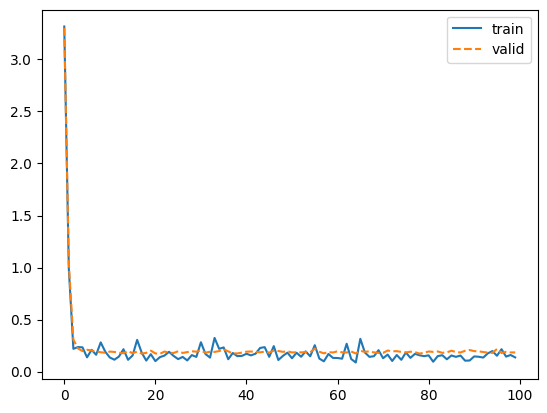

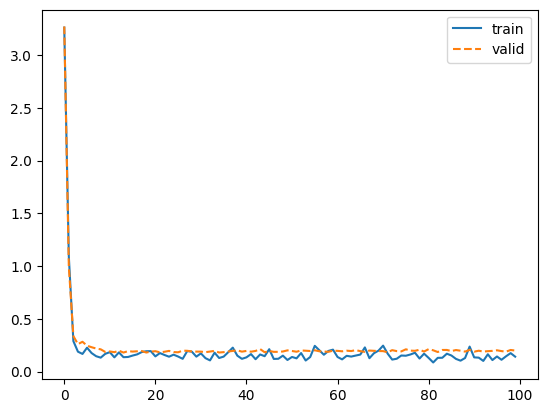

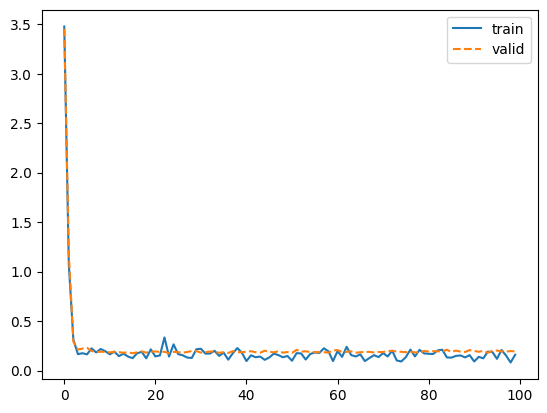

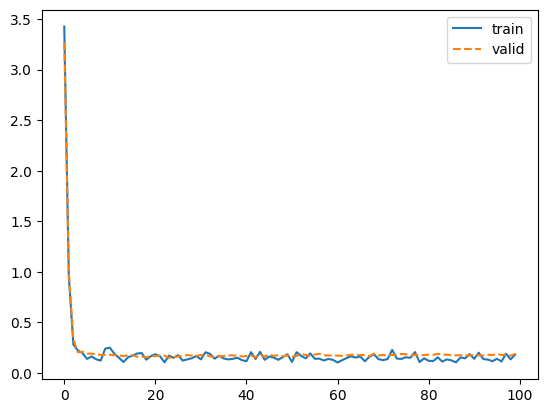

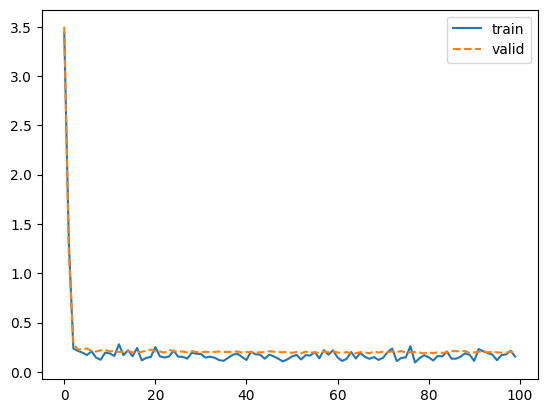

In [17]:
k, n_epochs, learning_rate, weight_decay, batch_size = 5, 100, 0.01, 0, 64
models = k_fold(k, train_set, train_labels, n_epochs, learning_rate, weight_decay, batch_size)

In [19]:
# preds = [model(test_set) for model in models]
preds = []
for model in models:
    model.eval()
    preds.append(model(test_set))
submission = pd.DataFrame({'Id': raw_test_set.Id, 'SalePrice': torch.cat(preds, 1).mean(1).detach().numpy()})
submission.to_csv('submission-mse-mlp2.csv', index=False)